## Group members:
* Aryan Gupta 2019A7PS0017G
* Shikha Bhat 2019A7PS0063G
* Taarush Bhatia 2019A7PS0159G

# Image Captioning
Image captioning aims to describe an image with
a concise, accurate, and interesting sentence. To
build such an automatic neural captioner, the traditional models align the generated words with a
number of human-annotated sentences to mimic
human-like captions. 

## Imports

In [27]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
import random
import re
from scipy import ndimage
from torch.autograd import Variable
from PIL import Image
import numpy as np

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparation of Dataset
We have used the [flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) dataset for image captioning. It has 8,091 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. 
* It is balanced because the images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.
* Similar to flickr8k, our paper used the MS COCO dataset, which is a subset of flickr30k. Both the datasets are created for solving image captioning problems. It also has 5 human annotated captions for each image. Thus, our dataset is quite similar to the one used in the paper but not the same.
* Initially, we tried to use the flickr30k dataset but due to limitations in GPU computation power and time constraints we switched to flickr8k which is a smaller dataset.

## Preprocessing

The Flickr8k dataset has 2 types of data: The images folder containing the 8091 RGB images in jpg format, and the captions.txt file containing the image ID and the corresponding 5 captions.

### Image Preprocessing
We are using the Python Imaging Library, which adds image processing capabilities.
We apply the following preprocessing steps to each image:
1. Scaling: Since not all images are of the same resolution, we resize the images to standard 224x224 dimensions with 3 channels.
2. ToTensor: Converted the images to pytorch tensor.
3. Normalise: Normalised the images to the required mean and std deviation.
We selected the values of the resolution and normalisation as per the requirement of Resnet18, which we've used for feature extraction.

In [29]:
class Image_Preprocessing():
    def __init__(self, data, dir):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
        self.dir = dir
        
    def __len__(self):  
        return len(self.data)
    
    def __getitem__(self, idx):

        image_name = self.data[idx]
        img_loc = self.dir+str(image_name)+'.jpg'

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

### Captions Preprocessing
To make the captions usable for our model, we first performed text preprocessing by removing all characters other than the space and those in the alphabet. We converted all text to lowercase and tokenised each word to a unique integer. We created the following data structures to store the captions for our use in the model:
* images: (Python list) list of all img_id
* vocab: (Python dictionary) all words in all available captions (vocabulary of the dataset) mapped to a unique integer
* rev_vocab: (Python dictionary) reverse mapping to identify word from integer
* img_desc: (Python dictionary) img_id mapped to a list of corresponding "clean" descriptions of image

In [30]:
file = open('../input/flickr8k/captions.txt', 'r')
ip_all = file.read()
file.close()

images = list()
img_desc = dict()
vocab = dict()
rev_vocab = dict()
index = 0

for line in ip_all.split('\n')[1:-1]:
    if '"' in line:
        ip = re.split(r',(?=")',line)
    else:
        ip = line.split(',')
        
    img = ip[0].split('.')[0]
    
    if img not in img_desc:
        img_desc[img] = list()
        images.append(img)
        
    clean_desc = "begseq "
    for ch in ip[1]:
        if ('A'<=ch and ch<='Z') or ('a'<=ch and ch<='z') or ch==' ':
            clean_desc += ch
    clean_desc += "endseq"
    clean_desc = clean_desc.lower()
    
    clean_desc_seq = list()
    for word in clean_desc.split():
        if word not in vocab:
            vocab[word] = index
            rev_vocab[index] = word
            index += 1
        clean_desc_seq.append(vocab[word])
    
    img_desc[img].append(clean_desc_seq)

In [31]:
print(len(images), len(img_desc), len(vocab), index, len(rev_vocab))

In [32]:
img_loc = '../input/flickr8k/Images/'
img_dataset = Image_Preprocessing(images, img_loc)
img_loader = torch.utils.data.DataLoader(img_dataset, batch_size = 1, shuffle=False)

# Deep Learning Models

We have used 2 major deep learning models for image caption generation - 
1. Resnet18 for feature extraction of images, which uses CNN
2. Word embedding folowed by LSTM for caption generation

The overall flow of the model is demonstrated by the following image -

![Model Flow](https://machinelearningmastery.com/wp-content/uploads/2017/09/Model-2-Generate-Word-From-Word.png)

## Feature Extraction Model
ResNet-18 is a convolutional neural network that is 18 layers deep. We have loaded a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. The architecture is as follows -



![](https://www.researchgate.net/profile/Paolo-Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png)

We are extracting features from the layer just before average pooling, with dimensions 512 * 7 * 7. This was done to reduce memory consumption on the GPU as the FC layers were finishing up our memory on Kaggle. The features of each image are stored as tensors in a Python dictionary "img_features".

In [33]:
feature_extraction = torchvision.models.resnet18(pretrained=True).to(device)
feature_extraction.eval()
resNet18Layer4 = feature_extraction._modules.get('layer4').to(device)


def get_vector(t_img):
    my_embedding = torch.zeros(1, 512, 7, 7)
    
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    h = resNet18Layer4.register_forward_hook(copy_data)
    feature_extraction(t_img)
    h.remove()
    return my_embedding
    

img_features = {}
for img_id, t_img in img_loader:
    t_img = t_img.to(device)
    feature = get_vector(t_img)
    img_features[img_id[0]] = feature

## Data Generation
We are using a many-to-many LSTM layer to generate image captions. The input and output of the layer are lists of length 3 each.
* The input to the LSTM layer is a list of 3 consecutive tokens from the image descriptions.
* The output of the LSTM layer is a list of 3 tokens that are supposed to be the next 3 words following the first token of the input.

The data is processed into a list such that each element is a pair of:
* A pair:
    * image ID
    * list of 3 input tokens
* list of the 3 expected output tokens

Train-Test Split - We divided the generated datagrams into training (90%) and testing (10%) datasets.

In [34]:
data = list()
sequence_length = 3
for img_id in images:
    for desc in img_desc[img_id]:
        for i in range(1,len(desc)-sequence_length-1):
            data.append([[img_id,desc[i:i+sequence_length]],desc[i+1:i+sequence_length+1]])

data_train = data[:(9*len(data))//10]
data_test = data[(9*len(data))//10:]

## Caption Generation Model


In [35]:
class Caption_Generation(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.added_layer = nn.Sequential(nn.Linear(7*7*512,256), nn.Dropout(0.2), nn.ReLU())
        
        self.embedding = nn.Embedding(len(vocab.keys()),256)
        self.lstm = nn.LSTM(256,256)

        self.dense = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,len(vocab.keys())),
            nn.ReLU()
        )
    
    def forward(self, x1, x2):
        ip1 = self.flatten(x1)
        ip1 = self.added_layer(ip1)
        ip2 = self.embedding(torch.LongTensor(x2))
        ip2 = self.lstm(ip2)
        ip = torch.add(ip1,ip2[0])
        out = self.dense(ip)
        return out

## Training and Testing

For training, we have used 2000 instances of the training dataset and for 3 epochs. This is a small scale training due to memory and time constraints. For now, we have used the cross entropy loss function, and measured the average loss and accuracy over an epoch. In each epoch, we call the test function to measure the improvement. For testing, we have used 50 instances of the testing dataset, and the same cross entropy loss function.

In [36]:
def train(train_data, test_data, epochs, model, optim, loss_f):

    model.train()
    
    for epoch in range(epochs):
        train_loss = 0.0
        for ip,op in train_data:
            optim.zero_grad()
            output = model(img_features[ip[0]], [ip[1]])[0]
            t_op = torch.LongTensor(op)
            loss = loss_f(output, t_op)
            train_loss += loss
            loss.backward()
            optim.step()
        train_loss /= len(train_data)        
        print('Epoch: ', epoch, 'Avg Train loss: ', float(train_loss))
        accuracy = test(test_data, model, loss_f)
        
def test(test_data, model, loss_f):
    model.eval()
    
    test_loss = 0
    correct = 0
    for ip,op in test_data:
        output = model(img_features[ip[0]], [ip[1]])[0] 
        t_op = torch.LongTensor(op)
        loss = loss_f(output, t_op)
        test_loss += loss
        next_word = torch.max(output[-1].view(1,-1), 1)[1]
        print("Predicted word: ", rev_vocab[int(next_word[0])], "Actual word: ", rev_vocab[op[-1]])
        correct += (int(next_word[0]) == op[-1])
    test_loss /= len(test_data)
    accuracy = 1. * int(correct) / len(test_data)
    print("Avg Test loss: ", float(test_loss), "accuracy: ", float(accuracy))
    
    return accuracy

## Caption Generation

* This is the main model which we are training.
* It takes two inputs x1, x2
* X1 is the feature vector we got from the resnet model for the images
* X2 n-gram word-gram where n is the sequence length, i.e. 3
* X1 is first flattened because the output from the 4th layer of resnet18 model is of shape 7x7 with 512 channels and we need to pass it through a linear layer to compress all the features
* The output from the flattened x1 is passed through a sequential layer with dropout to reduce chance of overfitting
* X2 is passed through an embedding layer to convert the word indexes to a word vector with 256 features representing each word.
* The output from the embedding layer is passed to the LSTM layer with 256 as the output size. The output is a tensor of shape n x 256 where n is the sequence length of word tensor passed in embedding layer, and each word having 256 features.
* The output from the LSTM layer is combined with the output of the added linear layer which is passed as input into a final Sequential layer which final gives  a feature length of the number of words in our vocabulary for each word in the output word-gram. 
* The maximum of the tensor of the last word position in the output word sequence will give the next predicted word for the input word sequence.
* This will be used to generate the caption.

In [37]:
caption_generation = Caption_Generation()

optimizer = torch.optim.Adam(caption_generation.parameters(), lr = 0.001)
loss = torch.nn.CrossEntropyLoss()

train(data_train[:500], data_test[:10], 5, caption_generation, optimizer, loss)

# Sample Test

In [38]:
def generate_caption(img_feature, caption, model):
    model.eval()
    output = model(img_feature, caption)[0]
    next_word = torch.max(output[-1].view(1,-1), 1)[1]
    caption[0].append(next_word)
    if next_word == vocab['endseq']:
        return caption
    if len(caption[0]) == 20:
        caption[0].append(vocab['endseq'])
        return caption
    return generate_caption(img_feature, caption, model)

In [39]:
import matplotlib.pyplot as plt
# random.seed(20)
img_id = images[random.randint(0,len(images)-1)]
print(img_id)
img = Image.open(img_loc+img_id+'.jpg')
imgplot = plt.imshow(img)
plt.show()

caption = generate_caption(img_features[img_id], [[0]], caption_generation)
for word_seq in caption[0]:
    print(rev_vocab[int(word_seq)], end = ' ')

## Results Analysis:
The reason our results are not accurate at all is because we are using only 500 instances of our entire data for training to demonstrate the working of our model. We have planned to shift our entire model to the GPU and will then train it with the full data.

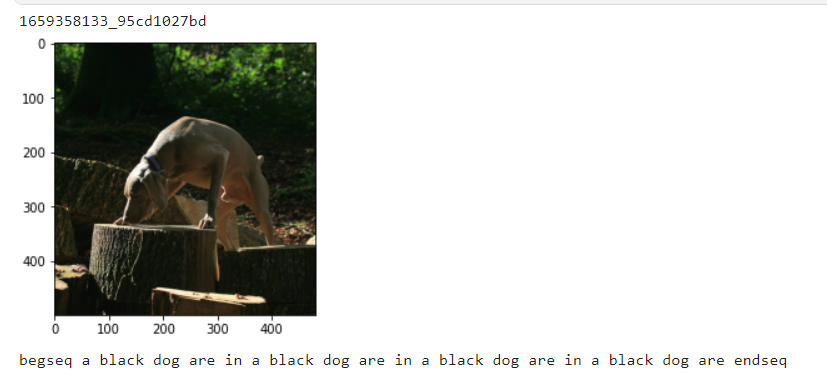

## Future Work:
1. Loss Function - Our paper uses a human-consensus oriented loss function, which we will implement for better quality image captions to be generated.


2. More training-Due to memory and time constraints, we were not able to train the caption generation model on the whole training dataset. We will work on this in the coming month.

3. Memory Resource Management-We will shift most of our processing to the GPU, so that it executes faster and gives us more space for training and testing. We also plan to implement garbage collection to manage memory efficiently.

4. Transformers - The paper uses another way of caption generation using transformers. We shall implement this in the future.

5. Comparison of performance using LSTMs and transformers, using various evaluation metrics.